## Imports

In [2]:
## Basic python libraries
import numpy as np
import pandas as pd
from IPython.display import Image, display

## Plotting
import matplotlib.pyplot as plt

I have decided to take a reinforcement learning approach to the question due to the future reward aspect. My goal is to use Q learning to determine the optimal route from the top of the triangle. Q learning is an off policy reinforcement learning technique using temporal difference (TD).

General terms:
- A policy is the probability of taking an action given the state the agent is in i.e. a relationship between state and action
- An action-value array (Q(state,action)) is an array of actions by state which is an approximation of the expected reward for taking a specific action in a specific state.
- Q-learning is off-policy because regardless of the action taken, the action-value array (Q) is updated with respect to the maximum expected future reward for being in the next state. This allows our agent over time to determine the optimal policy regardless if an action didn't return the best possible reward
- temporal difference (td) methods update the action value function using step wise updates instead of waiting for the entire reinforcement learning run to complete


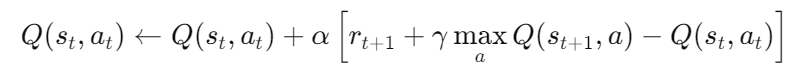

In [3]:
# Specify the path to your image
image_path = "path_to_your_image.jpg"

# Display the image
display(Image(filename="Q_learning_formula.png"))

The above formula is how the action-value array is updated at each step during Q-learning

- Alpha represents a learning rate (how large the update to the array should be at each time step)
- Gamma represents a discount factor, we weight the future reward less in comparison to the immediate reward received
- r(t+1) is the expected reward received after taking the action
- Q(st, at) is the action-value for the current state and action
- Q(st+1, at) is the action-value for the next state
- Temporal difference (TD) target is the estimate of the new state based on the immediate reward (the alpha term multiplied by the positive terms in the bracket)
- TD error is the difference TD target and the current estimate for the current state (the update term)

## Data Processing

In [4]:
## Import triangle
Triangle_DF = pd.read_csv("triangle.csv", header=None)

In [5]:
## Convert data to numpy array
Triangle_array = Triangle_DF.to_numpy()

In [6]:
## print numpy array
print(Triangle_array)

[[75. nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [95. 64. nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [17. 47. 82. nan nan nan nan nan nan nan nan nan nan nan nan]
 [18. 35. 87. 10. nan nan nan nan nan nan nan nan nan nan nan]
 [20.  4. 82. 47. 65. nan nan nan nan nan nan nan nan nan nan]
 [19.  1. 23. 75.  3. 34. nan nan nan nan nan nan nan nan nan]
 [88.  2. 77. 73.  7. 63. 67. nan nan nan nan nan nan nan nan]
 [99. 65.  4. 28.  6. 16. 70. 92. nan nan nan nan nan nan nan]
 [41. 41. 26. 56. 83. 40. 80. 70. 33. nan nan nan nan nan nan]
 [41. 48. 72. 33. 47. 32. 37. 16. 94. 29. nan nan nan nan nan]
 [53. 71. 44. 65. 25. 43. 91. 52. 97. 51. 14. nan nan nan nan]
 [70. 11. 33. 28. 77. 73. 17. 78. 39. 68. 17. 57. nan nan nan]
 [91. 71. 52. 38. 17. 14. 91. 43. 58. 50. 27. 29. 48. nan nan]
 [63. 66.  4. 68. 89. 53. 67. 30. 73. 16. 69. 87. 40. 31. nan]
 [ 4. 62. 98. 27. 23.  9. 70. 98. 73. 93. 38. 53. 60.  4. 23.]]


In [7]:
# Remove NaN values and convert each row to a list
Triangle = [row[~np.isnan(row)].tolist() for row in Triangle_array]

In [8]:
## Triangle is now a list of lists, with each list being a row from the triangle
print(Triangle)

[[75.0], [95.0, 64.0], [17.0, 47.0, 82.0], [18.0, 35.0, 87.0, 10.0], [20.0, 4.0, 82.0, 47.0, 65.0], [19.0, 1.0, 23.0, 75.0, 3.0, 34.0], [88.0, 2.0, 77.0, 73.0, 7.0, 63.0, 67.0], [99.0, 65.0, 4.0, 28.0, 6.0, 16.0, 70.0, 92.0], [41.0, 41.0, 26.0, 56.0, 83.0, 40.0, 80.0, 70.0, 33.0], [41.0, 48.0, 72.0, 33.0, 47.0, 32.0, 37.0, 16.0, 94.0, 29.0], [53.0, 71.0, 44.0, 65.0, 25.0, 43.0, 91.0, 52.0, 97.0, 51.0, 14.0], [70.0, 11.0, 33.0, 28.0, 77.0, 73.0, 17.0, 78.0, 39.0, 68.0, 17.0, 57.0], [91.0, 71.0, 52.0, 38.0, 17.0, 14.0, 91.0, 43.0, 58.0, 50.0, 27.0, 29.0, 48.0], [63.0, 66.0, 4.0, 68.0, 89.0, 53.0, 67.0, 30.0, 73.0, 16.0, 69.0, 87.0, 40.0, 31.0], [4.0, 62.0, 98.0, 27.0, 23.0, 9.0, 70.0, 98.0, 73.0, 93.0, 38.0, 53.0, 60.0, 4.0, 23.0]]


In [9]:
# print(len(Triangle[-1]))

In reinforcement learning we need to define an environment. It's purpose being to change the agent state given an action as well as returning a reward. For my case the reward is value of the specified route. Below is my Triangle Environment class

In [10]:
class TriangleEnv:
    def __init__(self, Triangle_Rewards):
        # Triangle properties
        self.reward_values = Triangle_Rewards ## Reward values from Triangle list of lists
        self.rows = len(Triangle)  # Number of rows in the triangle
        self.current_state = (0, 0)  # Starting state (i.e. top of triangle)
        self.terminal_states = self.rows - 1  # Terminal state row index
        self.actions = ["Down-Left", "Down-Right"]  # Possible actions

        ## Initialise current state to top
        self.current_state = (0,0)

    def get_reward(self, state):
        """Returns the reward for a given state."""

        ## Obtain reward value for being in state
        return self.reward_values[state[0]][state[1]]

    def make_step(self, action):
        """Moves the agent in the specified direction and returns the new state and reward."""

        ## Assign current state
        row, col = self.current_state

        ## Move state if Down-Left
        if action == "Down-Left":
            new_state = (row + 1, col)
        ## Move state if Down-Right
        elif action == "Down-Right":
            new_state = (row + 1, col + 1)

        ## Assign new state to current state
        self.current_state = new_state


        ## Obtain new state reward
        reward = self.get_reward(new_state)
            
        return self.current_state, reward

    def check_state(self):
        """Check if the agent is in a terminal state."""
        if self.current_state[0] == self.terminal_states:
            return "TERMINAL"
        return "NOT TERMINAL"

We define the Q learning agent which chooses an action given a state (follows a policy) and then updates the action-value space using the Q-learning formula. The policy below utilises epsilon greedy, the policy will randomly follow an action if our randomly selected variable is below a threshold (epsilon greedy). We will randomly draw a value between 0 and 1 and if it's less than epsilon we will randomly select an action. If it is greater we choose the greediest action with respect to expected reward i.e. the argmax of Q(state, action)

## Q Learning Agent

In [11]:
class QLearningAgent:
    def __init__(self, num_steps = 15, num_actions = 2, alpha=0.1, gamma=0.9, epsilon=0.3):
        ## Agent properties
        self.num_actions = num_actions # Number of actions i.e. two
        self.rows = num_steps # number of triangle rows
        self.alpha = alpha # Learning rate
        self.gamma = gamma # Future reward discount factor
        self.epsilon = epsilon # Epsilon greedy parameter for taking random action
        self.q_values = [] # action value array

        ## Create q_value list of Q value arrays corresponding to each row
        for idx in range(self.rows):
            self.q_values.append(np.zeros((idx + 1, num_actions))) # state x actions

        ## Random q_value initialisation
        self.q_values = [np.random.rand(i + 1, num_actions) * 0.01 for i in range(self.rows)]  # Small random values

    def choose_action(self, state):
        """Choose an action based on the epsilon-greedy policy."""

        ## obtain state
        row, col = state
        ## Choose a random action if random number is less than epsilon
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.choice(self.num_actions)  # Explore: random action
        
        ## Choose action based on the argmax of the current state (greedy action)
        else:
            return np.argmax(self.q_values[row][col])

    def learn(self, state, action, reward, next_state):
        """Update the Q-value for the given state-action pair."""
        ## obtain current and next state
        row, col = state
        next_row, next_col = next_state

        ## Determine the maximum Q-value for the next state (already chosen by the action)
        max_next_q_value = np.max(self.q_values[next_row][next_col])

        ## Calculate the TD target
        td_target = reward + self.gamma * max_next_q_value

        ## Calculate the TD error
        td_error = td_target - self.q_values[row][col][action]

        ## Update the Q-value for the current state-action pair
        self.q_values[row][col][action] += self.alpha * td_error

    def epsilon_change(self, epsilon_value):
        self.epsilon = epsilon_value

Next we define the experiment 

In [12]:
def play(environment, agent, trials=1000):
    """The play function runs iterations and updates Q-values."""
    reward_per_episode = []  # Initialize performance log

    for trial in range(trials):  # Run trials
        cumulative_reward = environment.reward_values[0][0]  # Initialize the cumulative reward for the episode
        max_steps_per_episode = environment.rows ## max steps per episode
        step = 0
        Terminal = False ## for terminating experiment

        # Reset the environment to the initial state for each trial
        environment.current_state = (0, 0)

        # Decrease exploration
        if trial == np.round(0.3*trials):
            agent.epsilon_change(0.05)

        while step < max_steps_per_episode and not Terminal:  # Run until max steps or terminal state
            old_state = environment.current_state  # Store the old state

            # Choose the next action from the agent
            action = agent.choose_action(old_state)
    
            # Gain reward feedback and new state from taking action in the environment
            new_state, reward = environment.make_step(environment.actions[action])
            
            # Update Q-values 
            agent.learn(old_state, action, reward, new_state)

            # Accumulate the reward
            cumulative_reward += reward
            
            # Increment step
            step += 1

            # Check if the environment is in a terminal state
            if environment.check_state() == "TERMINAL":
                Terminal = True       

        # Append the reward for the current trial to the performance log
        reward_per_episode.append(cumulative_reward)

    return reward_per_episode  # Return performance log

In [22]:
## Define environment
env = TriangleEnv(Triangle) ## Pass list of lists

## Define agent
agent = QLearningAgent(env.rows)

## Play game
reward_per_trials = play(environment= env, agent = agent, trials=10000)

max_reward = np.max(reward_per_trials) ## get max
Run_to_Max = np.argmax(reward_per_trials == max_reward) ## how long did it take to get max

max_count = np.sum(np.array(reward_per_trials) == max_reward)
print(f"The max reward is {max_reward}, It took {Run_to_Max} runs to obtain maximum reward")
print(f"The max route was chosen: {max_count} times")

The max reward is 1074.0, It took 719 runs to obtain maximum reward
The max route was chosen: 5050 times


The maximum value obtained is 1074, once the agent discovers the optimal route we observe roughly half the experiments obtain the maximum reward